# Bootstrap

У нас часто бывает потребность вычислить некоторую величину по выборке. Но точечная оценка далеко не всегда информативна и нам хочется получить дисперсию нашей оценки и посчитать доверительный интервал. В случаи когда искомая статистика это среднее, то можно аналитически выписать формулу для дисперсии нашей оценки.

Иногда нужно посчитать какую-то сложную статистику для которой трудно/невозможно посчитать аналитическую формулу. Сложности могут возникнуть уже при подсчете дисперсии медианы(как минимум у меня). В таких ситуациях стоит использовать bootstrap

In [1]:
import numpy as np
import scipy.stats as st
import os
import matplotlib.pyplot as plt
import multiprocessing as mp

from tqdm.notebook import tqdm
from typing import Optional, List, Tuple, Dict
from sklearn.metrics import precision_score, recall_score, f1_score

In [2]:
def hist(x: np.ndarray,
         bins: Optional[int] = None,
         density: bool = True,
         cumulative: bool = False,
         xlabel: Optional[str] = None,
         ylabel: Optional[str] = None,
         title: Optional[str] = None) -> None:
    plt.hist(x, bins=bins, density=density, cumulative=cumulative);
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

### Пример: медиана

In [3]:
# Сгенерируем нормальное распределение 
n_points = 1000
x = np.random.normal(1, 4, size=n_points)
median = np.median(x)
print('median:', median)

median: 0.9860091813326056


In [4]:
n_bootstraps = 10000
# сгенерируем n_bootstraps выборок с созвращением
bootstrapped_x = np.random.choice(x, size=(n_bootstraps, n_points))
# для каждой из них посчитаем медиану
bootstrapped_median = np.median(bootstrapped_x, axis=1)

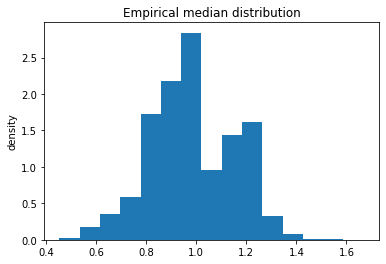

In [5]:
# Рассмотрим распределение медианы
hist(bootstrapped_median, bins=15, ylabel='density', title='Empirical median distribution')

Если есть функция распределения, то можно взять 0.025 и 0.975 квантили этого распределения и получим значение в котором случайная величина окажется в 95% случаев

In [6]:
bootstrapped_median = sorted(bootstrapped_median)
left = bootstrapped_median[int(n_bootstraps * 0.025)]
right = bootstrapped_median[int(n_bootstraps * 0.975)]

print(f'95% confidence interval: ({np.round(left, 4)}, {np.round(right, 4)})')
print(f'std: {np.std(bootstrapped_median)}')

95% confidence interval: (0.6659, 1.2819)
std: 0.17269509793311724


## Формально

Допустим что у нас есть выборка  $x_1, x_2, ..., x_i, ...,  x_n \sim F$  , наблюдения независимы. У нас есть некоторый статистический функционал $T = g( x_1, x_2, ..., x_i,..., x_n)$, и мы хотим посчитать $Var(T)$ или доверительный интервал.

**Алгоритм оценки дисперсии:**

1. Мы генерируем множество выборок($B$ штук) с возвращением типа $x_1^*, x_2^*, ..., x_i^*, ...,  x_n^*  \sim \widehat{F}$ 
2. Для каждой из них посчитаем нашу статистику, получаем $(T_1^*, T_2^*, ..., T_B^*)$ 
3. Теперь считаем дисперсию получившийся выборки и $Var(T)\sim Var(T^*)$  то есть: $V_{boot} = 1 \dfrac{1}{B} \sum_1^B (T_b^* - \frac{1}{B}\sum_{r=1}^B T_i^*)^2$


**Алгоритм оценки доверительного интервала**

Обозначения:

$\widehat{T} -$это точечная оценка нашей статистики полученная на исходной выборке

$\alpha -$ уровень значимости

*Нормальный интервал*

1. Находим дисперсию, способом выше, считаем $\widehat {se}_{boot} = \sqrt{V_{boot}}$  - оценка стандартной ошибки на основе бутстрепа.
2. Доверительный интервал: $\widehat{T} \pm z_{\alpha/2} * \widehat {se}_{boot}$, где  $z_{\alpha/2}$ - это квантиль нормального стандартного распределения

Метод хорошо работает, если распределение данных близко к нормальному распределению. 

*Центральный интервал*

1. Семплируем выборки.
2. Для каждой из них находим нашу статистику $T_i^*$
3. Считаем квантили получившийся выборки $T^*_{\alpha/2}$, $T^*_{1 - \alpha/2}$ 
4. Доверительный интервал: $(2 \widehat{T} - T^*_{1 - \alpha/2} , 2 \widehat{T} - T^*_{\alpha/2})$

Отлично работает в большинстве случаев, теоретически хорошо обоснован

*Интервал по процентилям*

1. Семплируем выборки.
2. Для каждой из них находим нашу статистику $T_i^*$
3. Считаем квантили получившийся выборки $T^*_{\alpha/2}$, $T^*_{1 - \alpha/2}$ 
4. Доверительный интервал: $(T^*_{\alpha/2} , T^*_{1 - \alpha/2})$

Хорошо работает с симметричными распределениями, могут быть проблемы с сильно скошенными.

На практике все 3 метода дают примерно одинаковый результат.

In [7]:
def compute_normal_confidence_interval(bootstraped_metric: List[float],
                                       estimate: Optional[float] = None,
                                       alpha: float = 0.05) -> Tuple[float, float]:
    # получаем квантили стандартного нормального распределения
    z_alpha = st.norm.ppf(1 - alpha / 2, loc=0.0, scale=1.0)
    se = np.std(bootstraped_metric)
    left = estimate - z_alpha * se
    right = estimate + z_alpha * se
    return left, right

def compute_percentiles_confidence_interval(bootstraped_metric: List[float],
                                       estimate: Optional[float] = None,
                                       alpha: float = 0.05) -> Tuple[float, float]:
    bootstraped_metric = np.sort(bootstraped_metric)
    n_bootstrap = len(bootstraped_metric)
    left = bootstraped_metric[int(alpha / 2 * n_bootstrap)]
    right = bootstraped_metric[int((1 - alpha / 2) * n_bootstrap)]
    return left, right

def compute_central_confidence_interval(bootstraped_metric: List[float],
                                       estimate: Optional[float] = None,
                                       alpha: float = 0.05) -> Tuple[float, float]:
    bootstraped_metric = np.sort(bootstraped_metric)
    n_bootstrap = len(bootstraped_metric)
    left = 2 * estimate - bootstraped_metric[int((1 - alpha / 2) * n_bootstrap)]
    right = 2 * estimate - bootstraped_metric[int(alpha / 2 * n_bootstrap)]
    return left, right

In [8]:
left, right = compute_normal_confidence_interval(bootstrapped_median, median)
print(f'95% normal confidence interval: ({np.round(left, 4)}, {np.round(right, 4)})')

left, right = compute_percentiles_confidence_interval(bootstrapped_median, median)
print(f'95% percentiles confidence interval: ({np.round(left, 4)}, {np.round(right, 4)})')

left, right = compute_central_confidence_interval(bootstrapped_median, median)
print(f'95% central confidence interval: ({np.round(left, 4)}, {np.round(right, 4)})')

95% normal confidence interval: (0.6475, 1.3245)
95% percentiles confidence interval: (0.6659, 1.2819)
95% central confidence interval: (0.6902, 1.3062)


## Доказательство

<img src="images/mem_proof.jpg"  width="500px" title="aaa">

Нужно понимать что когда мы генерируем выборки, то мы по сути используем оценку распределения $\widehat F$ вместо $F$. Где $\widehat F$ кусочно постоянная функция. Если бы мы семлировали выборки из истинного распределения то все было бы абсолютно легитимно. 

При этом есть Теорема __Гливенко — Кантелли:__

Пусть $X_{1},\ldots ,X_{n},\ldots $  - бесконечная выборка из распределения, задаваемого функцией распределения $F$. Пусть $\hat {F} $  - выборочная функция распределения, построенная на первых  $n$ элементах выборки. Тогда

$$\lim \limits _{n\to \infty }\sup \limits _{x\in \mathbb {R} }\left|{\hat {F}}(x)-F(x)\right|=0\; ~почти  ~ наверное$$

Это ключевая идея на которой основывается Bootstrap

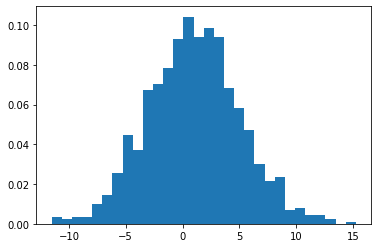

In [10]:
# относительно предыдущего примера: бутсрап работает так хорошо, как выборка похоже на нормальное распределение
hist(x, cumulative=False, bins=30)

__Важные допущения Bootstrap__

1) Элементы выборки независимы

2) Выборка репрезентативна

Если у нас есть понимание как эта функция должна себя вести, то можно поправить $\widehat F$, например сгладив ее с помощью ядерных методов. Тогда мы уже будет семплировать примеры из полноценной функции распределения и все элементы в выборках будут уникальные. Это позволит уменьшить доверительные интервалы.

__Замечание__: Добавление шума к элементам выборки при семплировании, аналогично сглаживанию эмпирической функции распределения.

**Сколько выборок нужно генерировать**

Всего выборок может быть $C_{2n-1}^n$ это очень много. Мы никак не можем влиять на то как эмпирическая функция распределения приближает истинную. И это будет влиять на нашу ошибку. Поэтому нет смысла бороться за сотые доли путем увеличения $B$ когда у нас уже ошибка в десятых за счет использования распределения $\widehat F$ вместо $F$ 

__Эвристика__: $B$ от 1k до 10k

**Когда bootstrap не работает**

Bootstrap плохо пригоден для оценивание "граничных" статистик таких как максимум или минимум. Им нельзя, например, правильно оценить дисперсию $\theta$, где $\theta$ это параметр равномерного распределения на отрезке $[0, \theta]$. Нужно чтобы случайная величина могла "шататься" в обе стороны

**Возможные косяки на понимание**

- Бутстрап не дает нам новой информации о искомой статистике, а только дает способ посчитать ее вариацию. Поэтому точечную оценку нашей статистку нужно оценивать по исходной выборке, т.е. оценка $mean(bootstraped\_statistic)$ неверное


- Может показаться что лучше бутстрапировать для каждой выборки не $n$(количество элементов в исходной выборке), а меньше(скажем $k$), ведь получаем меньше повторений и более "уникальные" выборки. Но это не верно, в этом случае мы будет оценивать дисперсию статистики по выборке из $k$ элементов а не $n$, то есть мы получим совсем другую дисперсию(завышенную оценку).


- Бутстрапировать выборки размером больше чем $n$(количество элементов в исходной выборке) абсолютно неверно. Контрпример: рассмотрим распределение Бернулли с параметром $p$. И попробуем оценить $p$ и $Var(p)$. Пусть у нас имеется выборка (0, 1), отсюда аналитически мы можем получить $\hat{p} = 0.5$ и $Var(\hat{p}) \sim 1$. А если бутстрапировать выборки вида (0, 1, 0, 0, 1, ..., 0, 1), то мы получим что $Var(\hat{p})\rightarrow 0$ что в корне не верно.

## Пример Классификация

Допустим что у нас есть сетка которая по картинкам делает предсказания кошка/собака и мы захотели вычислить f-score а также его вариативность

In [11]:
N = 100000
B = 1000
# генерируем датасет
true_values = np.random.randint(2, size=(N,))
predictions = (np.random.random((N, )) > 0.4).astype(int)
f_score = f1_score(true_values, predictions)
print('f_score:', f_score)
data = np.array(list(zip(true_values, predictions)))

f_score: 0.5477391942453865


Получили некоторую оценка работы, пока непонятно насколько это хорошо или плохо, Хочется понять насколько эта оценка статсзначима, какой ее разброс

In [12]:
# сэмплируем выборки
bootstrapped_data = np.random.choice(len(data), size=(B, N))
bootstrapped_data = data[bootstrapped_data]

In [13]:
# считаем распределение f-score
f1_score_distribution = []
for bootstrapped_sample in tqdm(bootstrapped_data):
    f1_score_distribution.append(f1_score(bootstrapped_sample[:, 0], bootstrapped_sample[:, 1]))

  0%|          | 0/1000 [00:00<?, ?it/s]

95% central confidence interval: (0.5443, 0.5512)


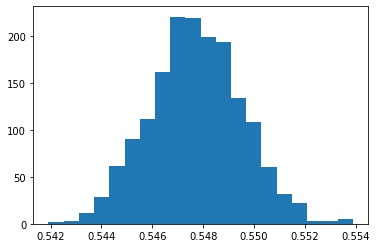

In [15]:
left, right = compute_central_confidence_interval(f1_score_distribution, f_score)
print(f'95% central confidence interval: ({np.round(left, 4)}, {np.round(right, 4)})')
hist(f1_score_distribution, cumulative=False, density=True, bins=20);

Каждая из выборок семплируется независимо, а это значит что bootstrap можно легко параллелить

In [16]:
def get_bootstrapped_metric(pair):
    data, seed = pair  # нужно передавать seed чтобы не получать одни и те же случайные подвыборки
    np.random.seed(seed)
    bootstrapped_data = np.random.choice(len(data), size=(N))
    bootstrapped_data = data[bootstrapped_data]
    return f1_score(bootstrapped_data[:, 0], bootstrapped_data[:, 1])

In [17]:
cpu_to_use = np.max([os.cpu_count() - 3, 1])
print('cpu_to_use:', cpu_to_use)

with mp.Pool(processes=cpu_to_use) as pool:
    f1_score_distribution = list(tqdm(pool.imap(get_bootstrapped_metric, ((data, i) for i in range(B)))))

cpu_to_use: 61


0it [00:00, ?it/s]

95% central confidence interval: (0.5443, 0.5513)


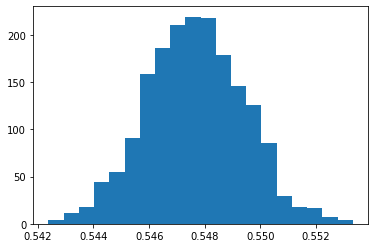

In [18]:
left, right = compute_central_confidence_interval(f1_score_distribution, f_score)
print(f'95% central confidence interval: ({np.round(left, 4)}, {np.round(right, 4)})')
hist(f1_score_distribution, cumulative=False, density=True, bins=20);

## Пример: семплирование статистик

Так как большинство метрик основываются на каких-то статистиках, то бывает удобно сэмплировать уже статистики для каждого примера.

Пример: Допустим что у нас есть модель детекции кошек на изображениях. Матчить и истинные и предсказанные боксы уже не самая быстрая операция, особенно если нужно ее повторять несколько тысяц раз для каждого примера. Можно заранее посчитать статистики для каждого изображения и потом семплировать уже их

In [19]:
N = 100
B = 10000
all_stats = []
total_stats = {'tp': 0, 'fp': 0, 'fn': 0}
for i in range(N):
    stats = {'tp': np.random.randint(0, 10),
             'fp': np.random.randint(0, 3),
             'fn': np.random.randint(0, 6)}
    all_stats.append(stats)
    for key, value in stats.items():
        total_stats[key] += value

In [22]:
# статистики на одном "изображении"
all_stats[1]

{'tp': 9, 'fp': 2, 'fn': 4}

In [23]:
# общие статистики по всему "датасету"
total_stats

{'tp': 434, 'fp': 96, 'fn': 268}

In [24]:
precision = total_stats['tp'] / (total_stats['tp'] + total_stats['fp'] + 1e-7)
recall = total_stats['tp'] / (total_stats['tp'] + total_stats['fn'] + 1e-7)
f_score = 2 * precision * recall / (precision + recall)
print('precision:', precision)
print('recall:', recall)
print('f_score:', f_score)

precision: 0.8188679243737985
recall: 0.6182336181455508
f_score: 0.7045454544310803


In [25]:
def _cumulative_sum(all_stats: List[Dict[str, int]]) -> Dict[str, int]:
    total_stats = {'tp': 0, 'fp': 0, 'fn': 0}
    for stats in all_stats:
        for key, value in stats.items():
            total_stats[key] += value
    return total_stats

In [26]:
def get_bootstrapped_metric(pair) -> Tuple[float, float, float]:
    all_stats, seed = pair
    np.random.seed(seed)
    all_stats = np.random.choice(all_stats, size=N)
    total_stats = _cumulative_sum(all_stats)
    precision = total_stats['tp'] / (total_stats['tp'] + total_stats['fp'] + 1e-7)
    recall = total_stats['tp'] / (total_stats['tp'] + total_stats['fn'] + 1e-7)
    f_score = 2 * precision * recall / (precision + recall)
    return (precision, recall, f_score)

In [27]:
cpu_to_use = np.max([os.cpu_count() - 3, 1])
print('cpu_to_use:', cpu_to_use)

with mp.Pool(processes=cpu_to_use) as pool:
    score_distribution = list(tqdm(pool.imap(get_bootstrapped_metric, ((all_stats, i) for i in range(B)))))
score_distribution = np.array(score_distribution)

cpu_to_use: 61


0it [00:00, ?it/s]

In [28]:
# Посчитаем доверительные интервалы для метрик
scores = (precision, recall, f_score)
for idx, score in enumerate(['precision', 'recall', 'f_score']):
    left, right = compute_central_confidence_interval(score_distribution[:, idx], scores[idx])
    print(f'{score} 95% central confidence interval: ({np.round(left, 4)}, {np.round(right, 4)})')

precision 95% central confidence interval: (0.7904, 0.851)
recall 95% central confidence interval: (0.5801, 0.6575)
f_score 95% central confidence interval: (0.6742, 0.7381)


## Linear Regression

Бутстреп дает также способ получать доверительные интервалы для коэффициентов(и любых других статистик) Линейных моделей

__Алгоритм__:

1) Обучаем модель и сохраняем предсказания $\widehat{y \,}_i $ и соответствующие остатки$\widehat{\varepsilon \,}_ {i} = y_{i} - {\widehat {y \,}}_{i}, (i = 1, \dots, n)$}

2) Для каждой пары $( x_i , y_i )$, добавляем остаток $\widehat {\varepsilon \,}_{j}$ , к истинному значению  $\widehat {y \,}_{i}$. Другими словами, создайте синтетические переменные ответа $\displaystyle y_{i}^{*} = {\widehat{y \,}} _{i} + {\widehat {\varepsilon \,}}_{j}$ где $j$ выбирается случайным образом из списка $(1,..., n )$ для каждого $i$ .

3) Обучаем модель используюя фиктивные переменные target $у_{i}^{*}$, сохраняем интересующие величины (например параметры,$\widehat {\mu}_{i}^{*}$, оцененный из синтетического $у_{i}^{*}$.

4) Повторите шаги 2 и 3 большое количество раз.


In [29]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

In [30]:
# Генерируем выборку с добавление шума
N_POINTS = 1000
x_1 = np.linspace(0, 3, N_POINTS)
x_2 = np.linspace(-4, 6, N_POINTS)
x_ones = np.array([1] * N_POINTS)
y = x_1 * 2 + x_2 * 5 + np.random.uniform(-1.5, 1.5, N_POINTS)

In [31]:
# Обучаем модель МНК и выписываем в том числе теоретические доверительные интервалы
data = np.array(list(zip(x_1, x_2)))
mod = sm.OLS(y, data)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 3.508e+05
Date:                Sun, 13 Nov 2022   Prob (F-statistic):               0.00
Time:                        20:35:48   Log-Likelihood:                -1272.6
No. Observations:                1000   AIC:                             2549.
Df Residuals:                     998   BIC:                             2559.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9941      0.024     82.699      0.000       1.947       2.041
x2             5.0065      0.014    366.451      0.000       4.980       5.033
==============================================================================
Omnibus:                      810.108   Durbin-Watson:                   1.853
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               61.266
Skew:                          -0.021   Prob(JB):                     4.97e-14
Kurtosis:                       1.788   Cond. No.                         3.25
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
# Обучаем линейную модель
model = LinearRegression(fit_intercept=False)
model.fit(data, y)
coefs = model.coef_
print(coefs)
# сохраняем предсказания и остатки
predicted_y = model.predict(data)
residuals = y - predicted_y

[1.99412671 5.00646974]


In [33]:
# Обучаем множество моделей с искривленным target и сохраняем коэффициенты
N_bootstraps = 1000
coef_list = []
for _ in tqdm(range(N_bootstraps)):
    random_residuals = np.random.choice(residuals, size=len(residuals), replace=True)
    new_y = predicted_y + random_residuals
    model = LinearRegression(fit_intercept=False)
    model.fit(data, new_y)
    coef_list.append(model.coef_)
# для удобства преобразовываем в numpy
coef_list = np.array(coef_list)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [34]:
# Посчитаем доверительные интервалы для коэффициентов
for coef_idx, coef in enumerate(coefs):
    left, right = compute_central_confidence_interval(coef_list[:, coef_idx], coef)
    print(f'95% central confidence interval for {coef_idx} coef: ({np.round(left, 4)}, {np.round(right, 4)})')

95% central confidence interval for 0 coef: (1.9492, 2.041)
95% central confidence interval for 1 coef: (4.9778, 5.0318)


## Poisson Bootsrap

Обычный бутстрап требует случайного выбора n элементов из списка, что эквивалентно извлечению из биноминального распределения распределения с параметрами $n$ и $1 / n$. 

__Справка__: биноминальное распределение - количество успехов среди n экспериметов.

То есть вместо того чтобы выбирать объект или нет, предсказывается сколько раз его взять. Конечно в этом случае в отдельной выборке количество примеров будет не равна n, однако при больших $n$ (в силу закона больших чисел) количество примеров будет близко к $n$

Далее биноминальное распределение с параметрами $n$ и $1 / n$ можно заменить на распределение Пуассона с параметром 1. Заметим что теперь нет зависимости от $n$. 

$$\displaystyle \lim _{n\to \infty }\operatorname {Binomial} (n,1/n)=\operatorname {Poisson} (1)$$

То есть чтобы определить сколько раз объект попадет в текущую бутстреп выборку не нужно заранее знать $n$!
Это означает что мы можем генерировать бутстреп на лету когда данные прилетают в потоке. Кроме того такое легче параллелить когда много данных

In [35]:
N = 10 ** 7 
N_bootstraps = 1000
threshold = 0.6
labels = np.random.randint(0,2,N)
predicts = (np.clip(np.random.normal(0.5,1, N),0,1) > threshold).astype(int)

In [36]:
mp.set_start_method('fork', force=True)
def poisson_bootstrap_tp_fp_fn_tn(data: List[Tuple[float, float, int]]) ->List[np.ndarray]:
    data = data[0]
    TP = np.zeros((N_bootstraps))
    FP = np.zeros((N_bootstraps))
    FN = np.zeros((N_bootstraps))
    TN = np.zeros((N_bootstraps))
    for current_label, current_predict, index in data:
        np.random.seed(index)
        p_sample = np.random.poisson(1, N_bootstraps)
        
        if current_label == 1 and current_predict == 1:
            TP += p_sample
        elif current_label == 1 and current_predict == 0:
            FN += p_sample
        elif current_label == 0 and current_predict == 1:
            FP += p_sample
        elif current_label == 0 and current_predict == 0:
            TN += p_sample
    return [TP, FP, FN, TN]

__Лирическое отступление__: для того чтобы понять насколько устойчив алгоритм классификации можно добавлять к выходу модели небольшой шум. И если между классами есть некоторый зазор то качество изомениться не должно. Если его нет или он маленький, то качество измениться в корне

In [37]:
# создаем генератор который будет выдавать пачки объектов размером chunk_size
chunk_size = 10 ** 5
generator = (
    (
        [
            (labels[x + y],
             predicts[x + y],
             x + y,
            )
            for x in range(chunk_size)
            if x + y < N
        ],
    )
        for y in range(0,N,chunk_size)
)

In [38]:
cpu_to_use = np.max([os.cpu_count() - 3,1])
print(cpu_to_use)

with mp.Pool(processes=cpu_to_use) as pool:
    stat_list = list(tqdm(pool.imap(poisson_bootstrap_tp_fp_fn_tn,generator),
                    total = N // chunk_size))

61


  0%|          | 0/100 [00:00<?, ?it/s]

In [39]:
stat_list = np.array(stat_list).sum(0) # просумируем статистики по всем батчам
f_score_list = []
for idx in range(N_bootstraps):
    tp, fp, fn, tn = stat_list[:, idx]
    precision = tp / (tp + fp + 1e-7)
    recall = tp / (tp + fn + 1e-7)
    f1 = 2 * precision * recall / (precision + recall)
    f_score_list.append(f1)

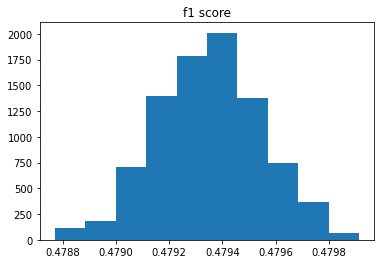

In [40]:
hist(f_score_list, title='f1 score')

Теперь воспользуемся обычным бутстрепом и посмотрим как быстро будет работать он

In [41]:
def get_bootstrapped_metric(bundle):
    data, seed = bundle
    np.random.seed(seed)
    bootstrapped_data = np.random.choice(len(data), size=(N))
    bootstrapped_data = data[bootstrapped_data]
    return f1_score(bootstrapped_data[:, 0], bootstrapped_data[:, 1])

In [42]:
data = np.array(list(zip(labels, predicts)))
print(data.shape)

(10000000, 2)


In [43]:
cpu_to_use = np.max([os.cpu_count() - 3, 1])
print(cpu_to_use)

with mp.Pool(processes=cpu_to_use) as pool:
    stat_list = list(tqdm(pool.imap(get_bootstrapped_metric, ((data, i) for i in range(N_bootstraps))),
                     total =N_bootstraps))

61


  0%|          | 0/1000 [00:00<?, ?it/s]

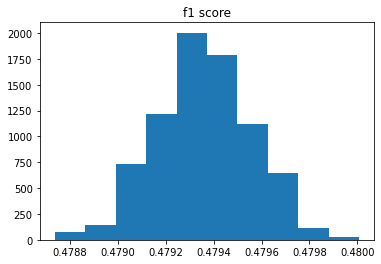

In [44]:
hist(stat_list, title='f1 score')

Мы видим те же результаты, при это Poisson Bootsrap в несколько раз быстрее!

### Дальнейшее чтение:

- [Лекция ШАДа по бутстрепу](https://disk.yandex.ru/i/-UuDEGlGVhbAeA)
- Слайды лекции ШАДа по бутстрепу(ниже)
    
    [lecture_5_bootstrap.pdf](https://s3-us-west-2.amazonaws.com/secure.notion-static.com/6b4c4475-5edb-4b07-afc6-d3cc706cd6ac/lecture_5_bootstrap.pdf)
    
- [Семинар ШАДа по бутстрепу](https://disk.yandex.ru/i/vngDpxiO5FOmFA)
- [bootstrapped - библиотека для бутстрепа](https://github.com/facebookarchive/bootstrapped)
- [abito - библиотека для статистики](https://github.com/avito-tech/abito)
- [Конспект Квантиль](http://quantile.ru/03/03-SA.pdf)
- [Лекция: Пуассон-Bootstrap](https://www.youtube.com/watch?v=Zki9VMzxcFU&t=1688s)